In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
import random
from sklearn.preprocessing import normalize

from collections import Counter
from scipy.stats import mode

In [2]:
exp_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\explod_feats.pt"
control_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\control_feats.pt"
sd_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\sd_feats.pt"
cosine_centroid_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\cosine\cosine_centroid.pt"


In [3]:
exp = torch.load(exp_save_path_torch)
control = torch.load(control_save_path_torch)
sd = torch.load(sd_save_path_torch)
cosine_centroid = torch.load(cosine_centroid_save_path_torch)
print(exp.shape)
print(control.shape)
print(sd.shape)
print(cosine_centroid.shape)

torch.Size([29, 512])
torch.Size([120, 512])
torch.Size([103, 512])
torch.Size([512])


C:\Users\k54739\AppData\Local\Temp\ipykernel_26596\3916985452.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_save_path_torch)
C:\Users\k54739\AppDa

In [4]:
# Convert features and labels to NumPy arrays
control_np = control.numpy()  # 120 Features in shape (120, 512)
control_np_norm = normalize(control_np, axis=1)
control_np_norm.shape

(120, 512)

In [5]:
sd_np = sd.numpy()  # 103 Features in shape (103, 512)
sd_np_norm = normalize(sd_np, axis=1)
sd_np_norm.shape

(103, 512)

In [6]:
exp_np = exp.numpy()  # 29 Features in shape (29, 512)
exp_np_norm = normalize(exp_np, axis=1)
exp_np_norm.shape


(29, 512)

In [7]:
exp_np_norm

array([[0.09942402, 0.        , 0.        , ..., 0.        , 0.        ,
        0.05314087],
       [0.05676892, 0.        , 0.00059459, ..., 0.        , 0.00559864,
        0.0914542 ],
       [0.03055801, 0.        , 0.00686699, ..., 0.        , 0.06694178,
        0.06710588],
       ...,
       [0.        , 0.00032315, 0.07815263, ..., 0.        , 0.06852816,
        0.07620089],
       [0.04429684, 0.        , 0.0148464 , ..., 0.        , 0.        ,
        0.13119867],
       [0.08297585, 0.        , 0.0030582 , ..., 0.        , 0.0054707 ,
        0.11982341]], dtype=float32)

In [8]:
cosine_centroid = cosine_centroid.numpy()
print(len(cosine_centroid))
cosine_centroid

512


array([1.15598113e-02, 4.67950372e-03, 6.05678811e-02, 3.97132080e-02,
       6.22929986e-02, 5.17932542e-02, 1.90802872e-02, 8.08006403e-03,
       3.38454371e-02, 9.24501245e-02, 4.76434767e-02, 2.14309413e-04,
       1.47157980e-02, 4.39299084e-02, 2.07922707e-02, 8.76266483e-02,
       4.51024099e-03, 2.02452289e-02, 1.02720359e-01, 3.36181500e-02,
       5.73134539e-02, 4.59700931e-02, 1.96533594e-02, 4.41949990e-02,
       4.64943211e-02, 8.68415164e-02, 2.48886070e-03, 3.11143059e-02,
       3.19192448e-02, 3.00994783e-02, 5.24901817e-02, 5.94389127e-02,
       1.92603947e-02, 4.25757926e-02, 5.99674322e-04, 8.55245156e-02,
       3.23484668e-02, 1.06046327e-01, 6.63184118e-02, 5.65145204e-03,
       2.28252425e-03, 5.34213348e-03, 8.30309599e-03, 5.05610267e-02,
       1.51367160e-02, 2.51264247e-02, 1.20286566e-02, 7.87353398e-02,
       1.38669667e-02, 3.57596289e-03, 1.14059459e-01, 5.19641733e-02,
       9.90687800e-03, 2.19089293e-02, 6.54568893e-02, 3.10062713e-02,
      

In [19]:
import numpy as np

# Calculate the L2 norm of each row in exp_np_norm
norms = np.linalg.norm(exp_np_norm, axis=1)

# Check if all norms are close to 1
if np.allclose(norms, 1.0, atol=1e-6):
    print("All feature vectors are normalized.")
else:
    print("Some feature vectors are not normalized.")
    print("Norms:", norms)


All feature vectors are normalized.


In [9]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Ensure cosine centroid is a 2D array with shape (1, 512)
cosine_centroid = cosine_centroid.reshape(1, -1)  # Shape: [1, 512]

# Calculate cosine distances for each dataset
control_cosine_distances = 1 - cosine_similarity(control_np_norm, cosine_centroid).flatten()  # Shape: [120]
exp_cosine_distances = 1 - cosine_similarity(exp_np_norm, cosine_centroid).flatten()  # Shape: [29]
sd_cosine_distances = 1 - cosine_similarity(sd_np_norm, cosine_centroid).flatten()  # Shape: [103]

# Print shapes to verify
print("Control Cosine Distances Shape:", control_cosine_distances.shape)  # Should be [120]
print("Exp Cosine Distances Shape:", exp_cosine_distances.shape)          # Should be [29]
print("SD Cosine Distances Shape:", sd_cosine_distances.shape)            # Should be [103]


Control Cosine Distances Shape: (120,)
Exp Cosine Distances Shape: (29,)
SD Cosine Distances Shape: (103,)


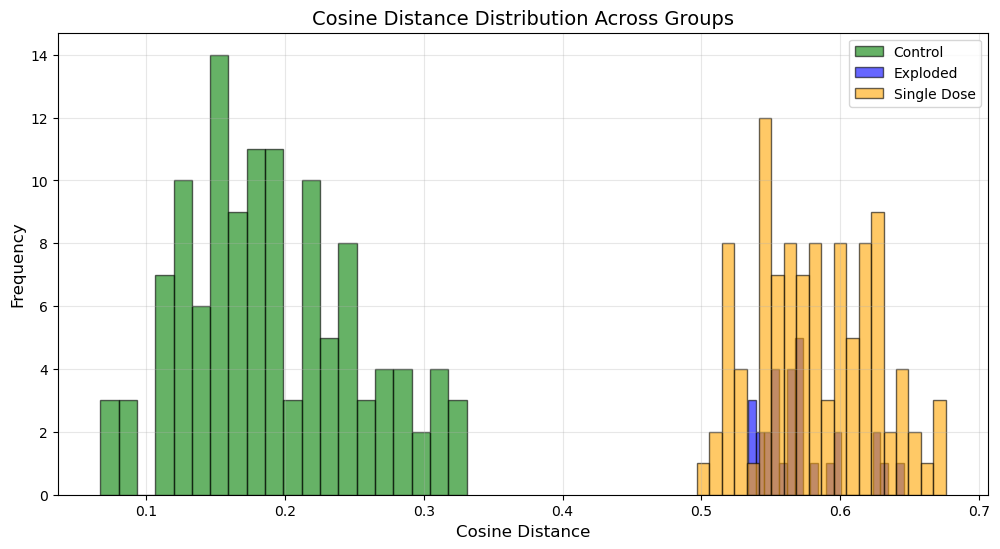

In [10]:
import matplotlib.pyplot as plt
# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(control_cosine_distances, bins=20, alpha=0.6, label="Control", color="green", edgecolor="black")
plt.hist(exp_cosine_distances, bins=20, alpha=0.6, label="Exploded", color="blue", edgecolor="black")
plt.hist(sd_cosine_distances, bins=20, alpha=0.6, label="Single Dose", color="orange", edgecolor="black")

# Customize plot
plt.title("Cosine Distance Distribution Across Groups", fontsize=14)
plt.xlabel("Cosine Distance", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# Show plot
plt.show()

In [1]:
import torch
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def calculate_and_plot_cosine_distances(exp_path, control_path, sd_path, centroid_path, bins=20):
    """
    Calculate cosine distances between a centroid and features from multiple groups,
    then plot histograms of these distances.

    Parameters:
        exp_path (str): Path to the exploded features .pt file.
        control_path (str): Path to the control features .pt file.
        sd_path (str): Path to the single-dose features .pt file.
        centroid_path (str): Path to the centroid .pt file.
        bins (int): Number of bins for the histogram.
    """
    # Load data
    exp = torch.load(exp_path)
    control = torch.load(control_path)
    sd = torch.load(sd_path)
    cosine_centroid = torch.load(centroid_path)

    # Convert tensors to NumPy arrays and normalize
    exp_np_norm = normalize(exp.numpy(), axis=1)
    control_np_norm = normalize(control.numpy(), axis=1)
    sd_np_norm = normalize(sd.numpy(), axis=1)

    # Ensure centroid is reshaped correctly
    cosine_centroid = cosine_centroid.numpy().reshape(1, -1)  # Shape: [1, 512]

    # Calculate cosine distances
    control_cosine_distances = 1 - cosine_similarity(control_np_norm, cosine_centroid).flatten()
    exp_cosine_distances = 1 - cosine_similarity(exp_np_norm, cosine_centroid).flatten()
    sd_cosine_distances = 1 - cosine_similarity(sd_np_norm, cosine_centroid).flatten()

    # Plot histograms
    plt.figure(figsize=(12, 6))
    plt.hist(control_cosine_distances, bins=bins, alpha=0.6, label="Control", color="green", edgecolor="black")
    plt.hist(exp_cosine_distances, bins=bins, alpha=0.6, label="Exploded", color="blue", edgecolor="black")
    plt.hist(sd_cosine_distances, bins=bins, alpha=0.6, label="Single Dose", color="orange", edgecolor="black")

    # Customize plot
    plt.title("Cosine Distance Distribution Across Groups", fontsize=14)
    plt.xlabel("Cosine Distance", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)

    # Show plot
    plt.show()

    # Return calculated distances for further use
    return {
        "control_cosine_distances": control_cosine_distances,
        "exp_cosine_distances": exp_cosine_distances,
        "sd_cosine_distances": sd_cosine_distances
    }


C:\Users\k54739\AppData\Local\Temp\ipykernel_14080\4185590733.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\T

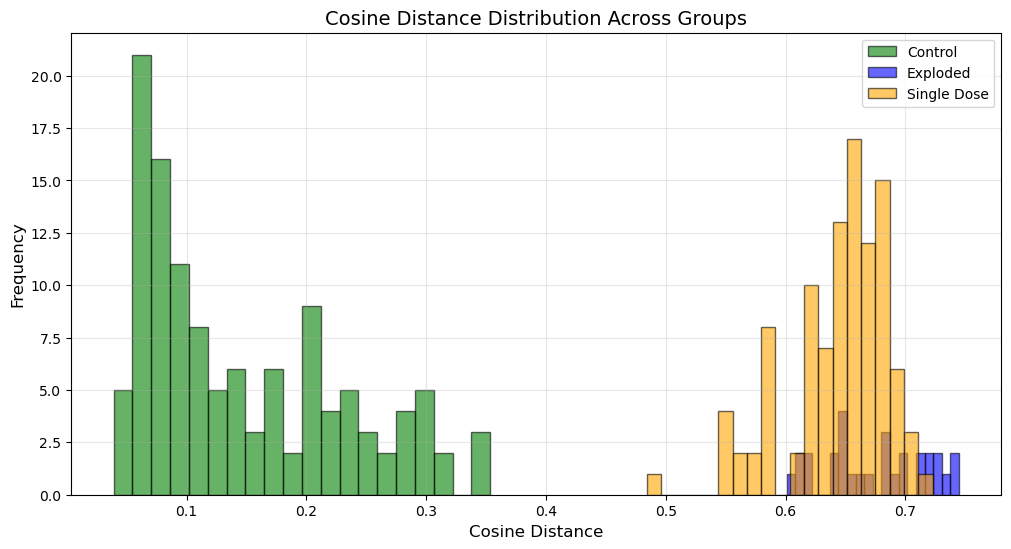

In [2]:
# File paths
exp_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\beforeResize_ex_29.pt"
control_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\beforeResize_control_120.pt"
sd_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\beforeResize_sd_103.pt"
cosine_centroid_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\cosine\before_3class_resize_cosine_centroid_tensor.pt"

# Call the function
distances = calculate_and_plot_cosine_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    cosine_centroid_save_path_torch,
    bins=20
)

# Access distances if needed
control_distances = distances["control_cosine_distances"]
exp_distances = distances["exp_cosine_distances"]
sd_distances = distances["sd_cosine_distances"]


In [5]:
cosine_centroid = torch.load(cosine_centroid_save_path_torch)
# Example: Checking the type
print(type(cosine_centroid))

<class 'numpy.ndarray'>


C:\Users\k54739\AppData\Local\Temp\ipykernel_16528\681077827.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cosine_centroid = torch.load(cosine_centroid_save_path_torch

In [4]:
cosine_centroid = cosine_centroid.numpy().reshape(1, -1)

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'